In [1]:
import pandas as pd
import numpy as np

In [2]:
#!git clone https://github.com/gautampawnesh/learntools.git
#!cd learntools
#!python setup.py install


In [3]:
from learntools.time_series.style import plot_params
from learntools.time_series.utils import seasonal_plot, plot_periodogram


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [6]:
#!pip install statsmodels


### Data Information

- **train.csv**
-- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- **store_nbr** identifies the store at which the products are sold.
- **family** identifies the type of product sold.
- **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

In [7]:
train_df = pd.read_csv("../dataset/store-sales-time-series-forecasting/train.csv")

In [8]:
train_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


#### Test data

- The test data, having the same features as the training data. You will predict the target **sales** for the dates in this file.
- The dates in the test data are for the 15 days after the last date in the training data.

In [9]:
test_df = pd.read_csv("../dataset/store-sales-time-series-forecasting/test.csv")

In [10]:
test_df

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


#### Store data

- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.

In [11]:
store_df = pd.read_csv("../dataset/store-sales-time-series-forecasting/stores.csv")

In [12]:
store_df

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


#### Oil data

- Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [13]:
oil_df = pd.read_csv("../dataset/store-sales-time-series-forecasting/oil.csv")

In [14]:
oil_df

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


#### Holiday Events

- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).


In [15]:
holiday_df = pd.read_csv("../dataset/store-sales-time-series-forecasting/holidays_events.csv")

In [16]:
holiday_df

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [17]:
holiday_df[holiday_df["transferred"]== True]

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


### Data Loading

In [18]:
train_df = pd.read_csv("../dataset/store-sales-time-series-forecasting/train.csv",
                      dtype={
                          "store_nbr": "category",
                          "family": "category",
                          "sales": "float32",
                          "onpromotion": "uint64"
                      },
                      parse_dates=["date"],
                      infer_datetime_format=True,
                      usecols=["date", "store_nbr", "family", "sales", "onpromotion"]
                      )

In [19]:
train_df

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.000000,0
1,2013-01-01,1,BABY CARE,0.000000,0
2,2013-01-01,1,BEAUTY,0.000000,0
3,2013-01-01,1,BEVERAGES,0.000000,0
4,2013-01-01,1,BOOKS,0.000000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.132996,0
3000884,2017-08-15,9,PREPARED FOODS,154.552994,1
3000885,2017-08-15,9,PRODUCE,2419.729004,148
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8


In [20]:
train_df.date.info()

<class 'pandas.core.series.Series'>
RangeIndex: 3000888 entries, 0 to 3000887
Series name: date
Non-Null Count    Dtype         
--------------    -----         
3000888 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 22.9 MB


In [21]:
train_df["date"] = train_df.date.dt.to_period("D")

In [22]:
train_df.date.info()

<class 'pandas.core.series.Series'>
RangeIndex: 3000888 entries, 0 to 3000887
Series name: date
Non-Null Count    Dtype    
--------------    -----    
3000888 non-null  period[D]
dtypes: period[D](1)
memory usage: 22.9 MB


In [23]:
train_df

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.000000,0
1,2013-01-01,1,BABY CARE,0.000000,0
2,2013-01-01,1,BEAUTY,0.000000,0
3,2013-01-01,1,BEVERAGES,0.000000,0
4,2013-01-01,1,BOOKS,0.000000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.132996,0
3000884,2017-08-15,9,PREPARED FOODS,154.552994,1
3000885,2017-08-15,9,PRODUCE,2419.729004,148
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8


In [24]:
train_df.set_index(["date", "store_nbr", "family"]).sort_index()

sales  onpromotion
date       store_nbr family                                              
2013-01-01 1         AUTOMOTIVE                     0.000000            0
                     BABY CARE                      0.000000            0
                     BEAUTY                         0.000000            0
                     BEVERAGES                      0.000000            0
                     BOOKS                          0.000000            0
...                                                      ...          ...
2017-08-15 9         POULTRY                      438.132996            0
                     PREPARED FOODS               154.552994            1
                     PRODUCE                     2419.729004          148
                     SCHOOL AND OFFICE SUPPLIES   121.000000            8
                     SEAFOOD                       16.000000            0

[3000888 rows x 2 columns]

In [25]:
train_df = train_df.set_index(["date", "store_nbr", "family"]).sort_index()

In [26]:
train_df.tail(20)

sales  onpromotion
date       store_nbr family                                              
2017-08-15 9         GROCERY II                     9.000000            0
                     HARDWARE                       1.000000            0
                     HOME AND KITCHEN I            64.000000            0
                     HOME AND KITCHEN II           61.000000            2
                     HOME APPLIANCES                0.000000            0
                     HOME CARE                    373.000000            6
                     LADIESWEAR                    10.000000            0
                     LAWN AND GARDEN               11.000000            3
                     LINGERIE                       6.000000            0
                     LIQUOR,WINE,BEER              25.000000            2
                     MAGAZINES                     11.000000            0
                     MEATS                        449.227997            0
                     PERSONAL CARE                522.000000           11
                     PET SUPPLIES                   6.000000            0
                     PLAYERS AND ELECTRONICS        6.000000            0
                     POULTRY                      438.132996            0
                     PREPARED FOODS               154.552994            1
                     PRODUCE                     2419.729004          148
                     SCHOOL AND OFFICE SUPPLIES   121.000000            8
                     SEAFOOD                       16.000000            0

### Data Exploration

**Trend Analysis**

- Using **Moving Average plot** to discover trend 

In [27]:
average_sales= train_df.groupby("date").mean()["sales"]

In [28]:
# Rolling mean with a window length of 365(1 year) observations.
moving_average = average_sales.rolling(window=365, center=True, min_periods=183).mean()

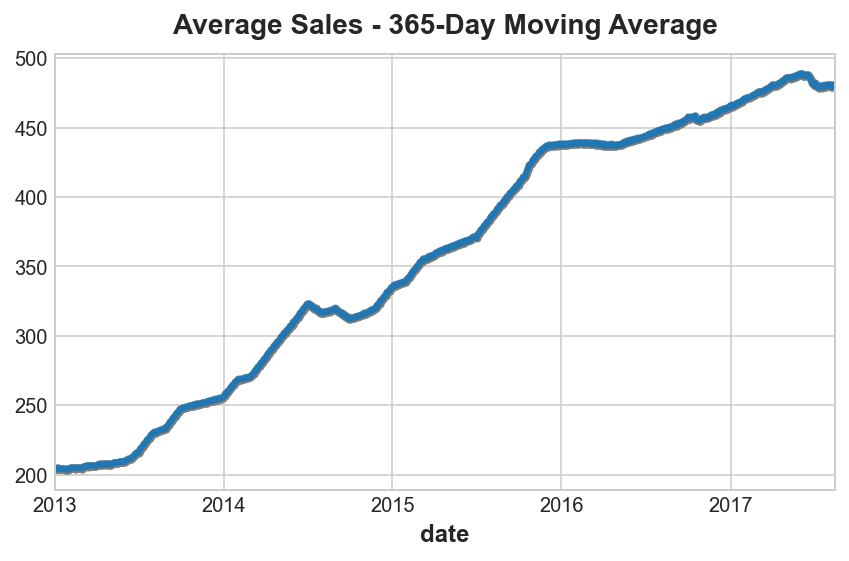

In [29]:
ax = moving_average.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Average Sales - 365-Day Moving Average", legend=False,
);

**Seasonality**

- Here I will look into two kind of features to check seasonality. 
- The first kind, indicators, is best for a season with few observations, like a weekly season of daily observations.

- The second kind, Fourier features, is best for a season with many observations, like an annual season of daily observations.

- using seasonal plot to discover seasonality

In [30]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

In [31]:
X

,sales,week,day,dayofyear,year
date,,,,,
2013-01-01,1.409438,1,1,1,2013
2013-01-02,278.390808,1,2,2,2013
2013-01-03,202.840195,1,3,3,2013
2013-01-04,198.911148,1,4,4,2013
2013-01-05,267.873230,1,5,5,2013
...,...,...,...,...,...
2017-08-11,463.733856,32,4,223,2017
2017-08-12,444.798279,32,5,224,2017
2017-08-13,485.768616,32,6,225,2017


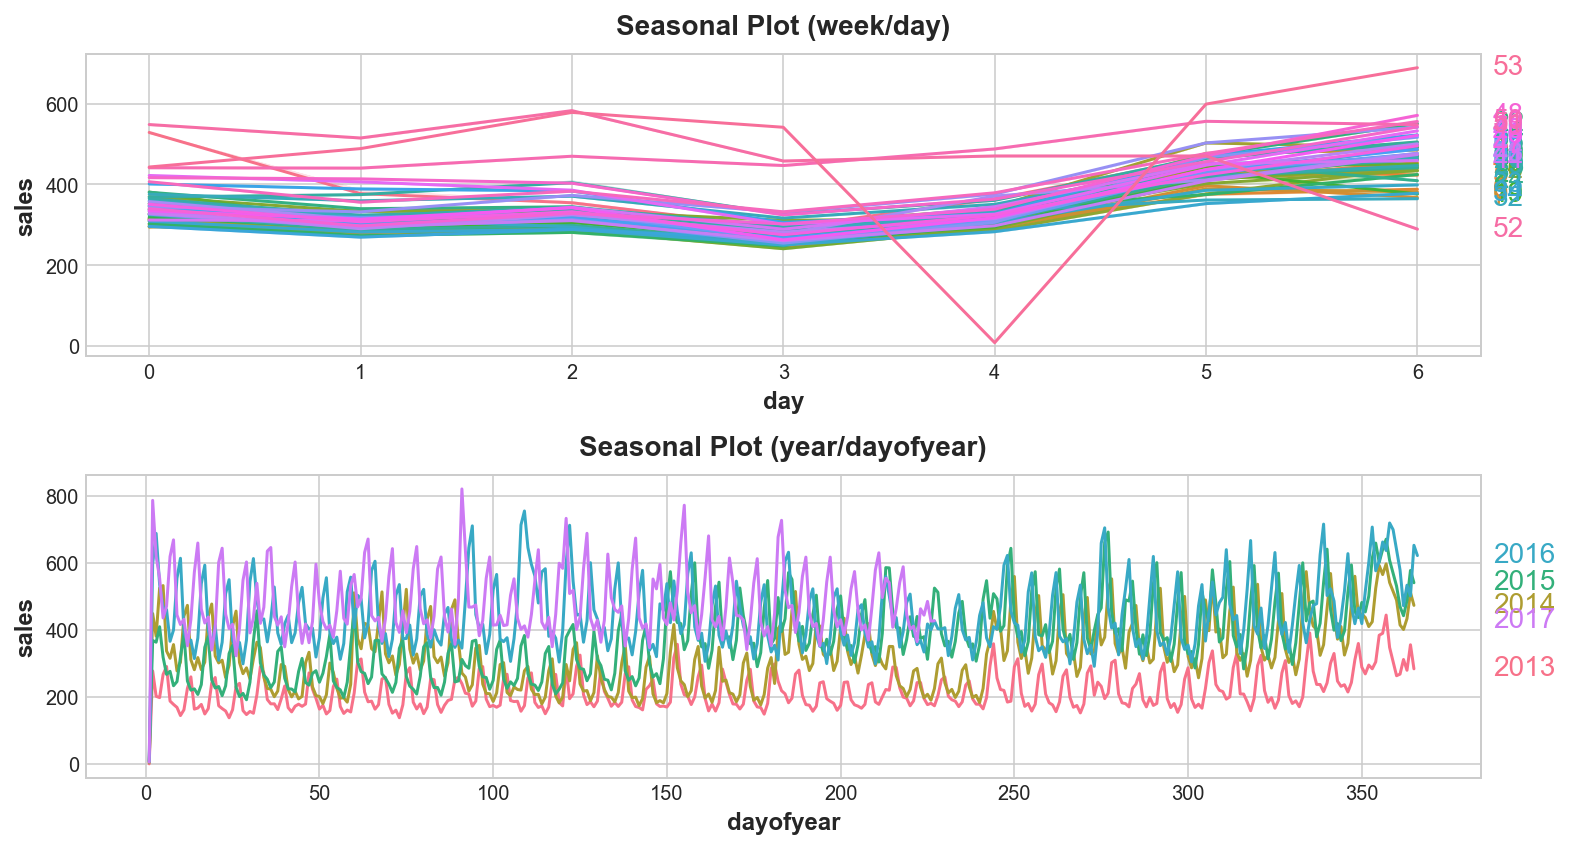

In [32]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);

In [33]:
X_2017 = average_sales.loc["2017"].to_frame()
X_2017["week"] = X_2017.index.week
X_2017["day"] = X_2017.index.dayofweek

# days within a year
X_2017["dayofyear"] = X_2017.index.dayofyear
X_2017["year"] = X_2017.index.year

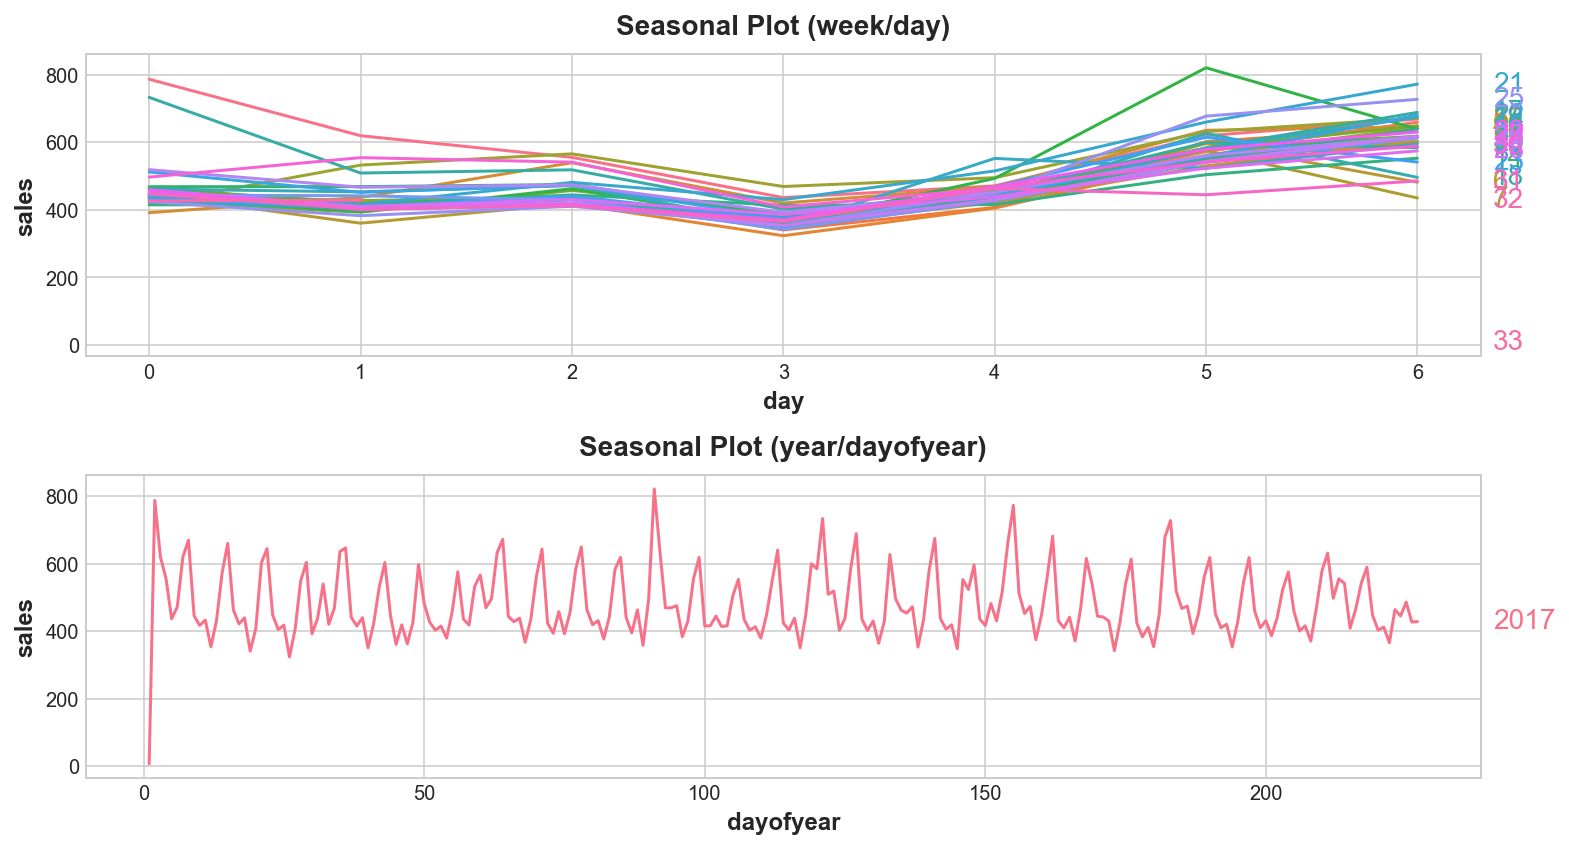

In [34]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X_2017, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X_2017, y="sales", period="year", freq="dayofyear", ax=ax1);

- Periodogram

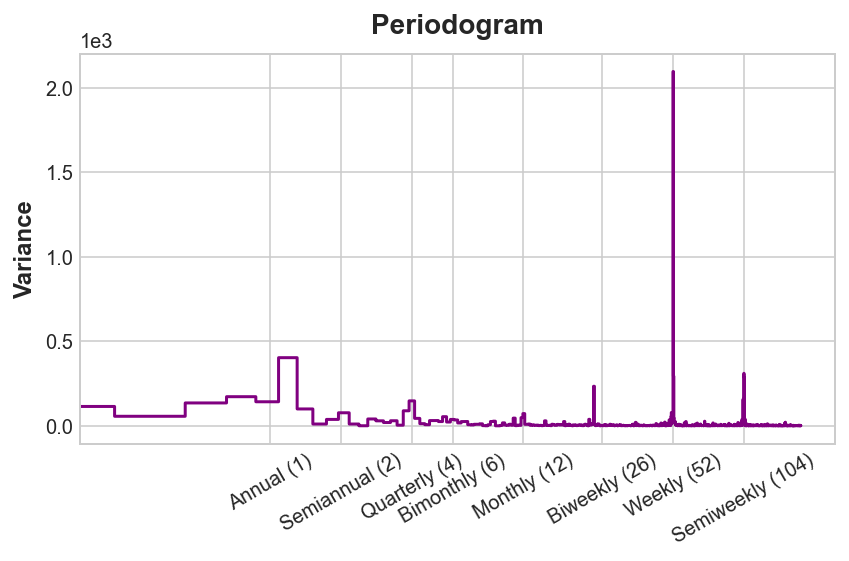

In [35]:
plot_periodogram(X.sales);

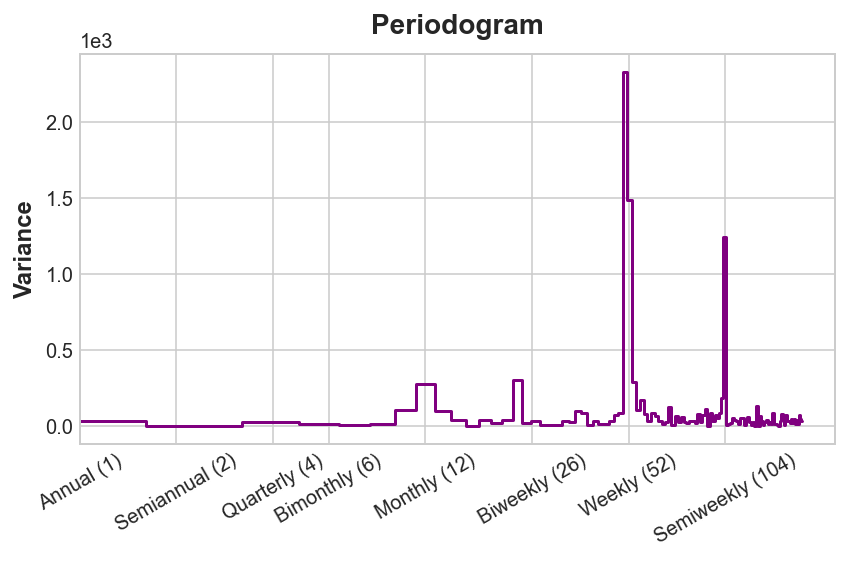

In [36]:
plot_periodogram(X_2017.sales);

- Periodogram agrees with seasonality plot, strong weekly seasonaly and weaker annual season

- **Time Dependence**

- A deterministic process, by the way, is a technical term for a time series that is non-random or completely determined, like the const and trend series are.
- Features derived from the time index will generally be deterministic.

In [38]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=X.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

XX = dp.in_sample()  # create features for dates in X.index

In [39]:
XX

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,...,0.103102,0.994671,0.120208,0.992749,0.137279,0.990532,0.154309,0.988023,0.171293,0.985220
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,...,0.205104,0.978740,0.238673,0.971100,0.271958,0.962309,0.304921,0.952378,0.337523,0.941317
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,...,0.304921,0.952378,0.353676,0.935368,0.401488,0.915864,0.448229,0.893919,0.493776,0.869589
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,...,0.401488,0.915864,0.463550,0.886071,0.523416,0.852078,0.580800,0.814046,0.635432,0.772157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,1680.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.628763,-0.777597,...,-0.806480,-0.591261,0.998880,-0.047321,-0.746972,0.664855,0.162807,-0.986658,0.493776,0.869589
2017-08-12,1.0,1681.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.642055,-0.766659,...,-0.863142,-0.504961,0.985948,-0.167052,-0.648630,0.761104,0.008607,-0.999963,0.635432,0.772157
2017-08-13,1.0,1682.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.655156,-0.755493,...,-0.910605,-0.413279,0.958718,-0.284359,-0.538005,0.842942,-0.145799,-0.989314,0.758306,0.651899


**Modeling**

In [40]:
from sklearn.linear_model import LinearRegression

In [41]:
y = X["sales"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(XX, y)

y_pred = pd.Series(model.predict(XX), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)


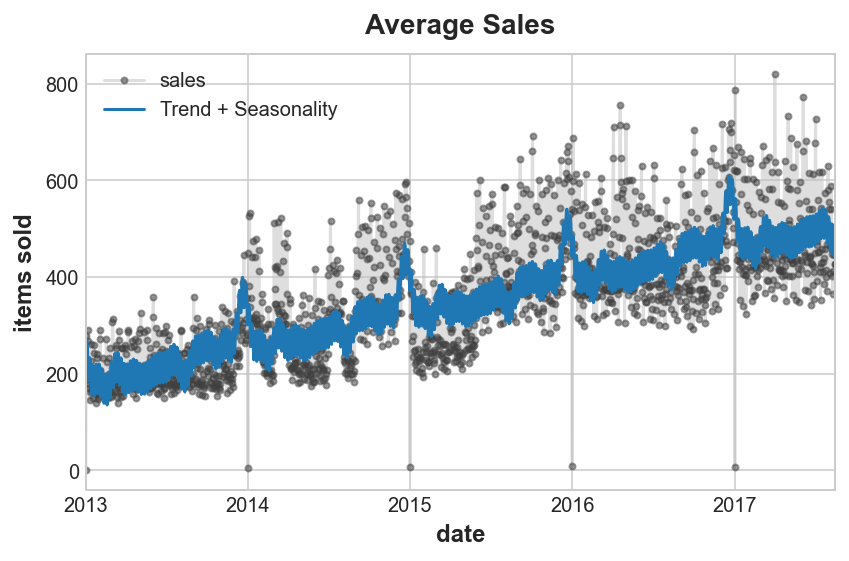

In [42]:
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Trend + Seasonality")
ax.legend();

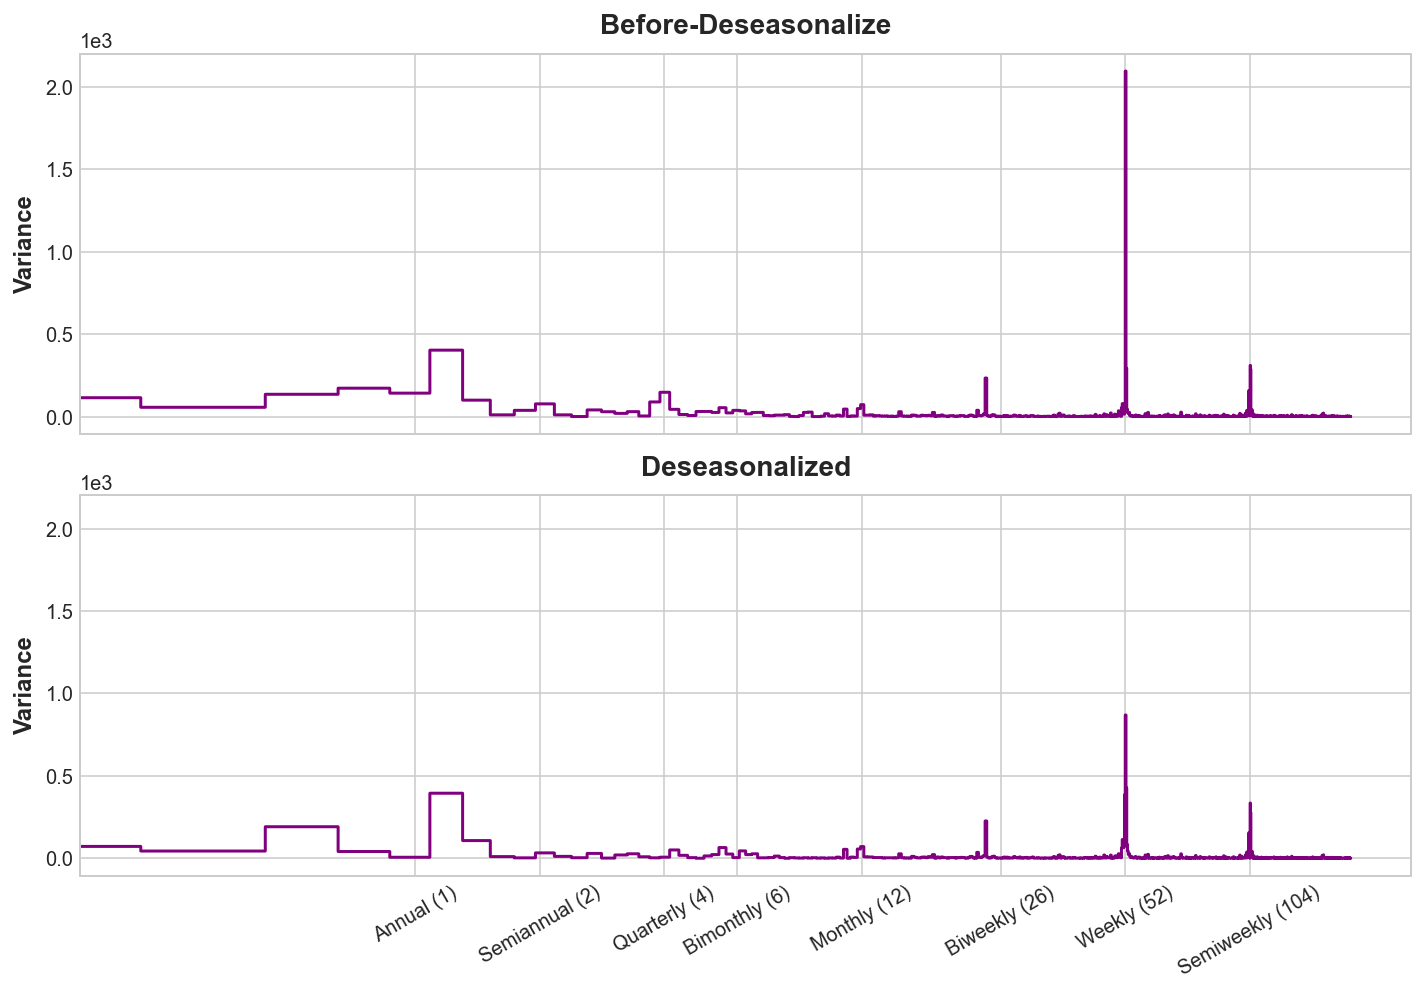

In [43]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Before-Deseasonalize")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

In [44]:
fourier = CalendarFourier(freq="M", order=4)  # 4 sin/cos pairs for "M"onthly seasonality

dp = DeterministicProcess(
    index=X_2017.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

XX = dp.in_sample()  # create features for dates in X.index

In [45]:
y = X_2017["sales"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(XX, y)

y_pred = pd.Series(model.predict(XX), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)


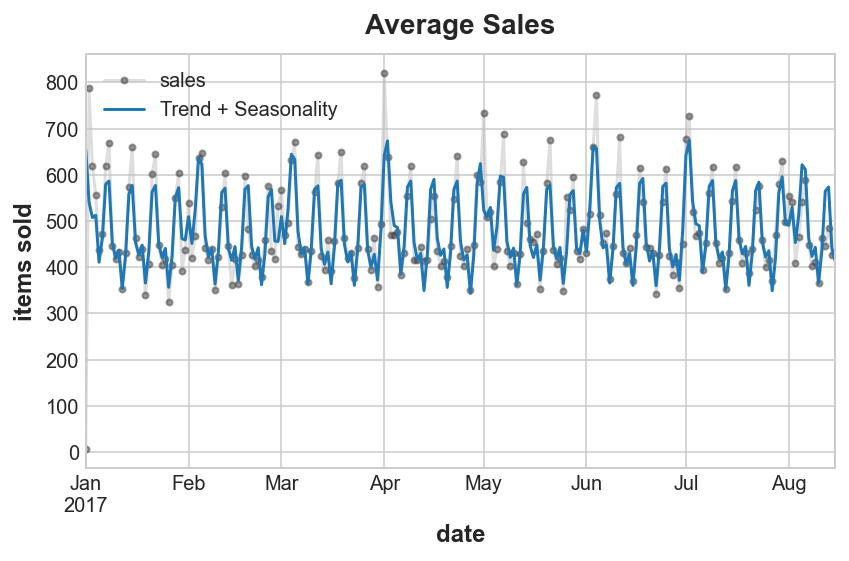

In [46]:
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Trend + Seasonality")
ax.legend();

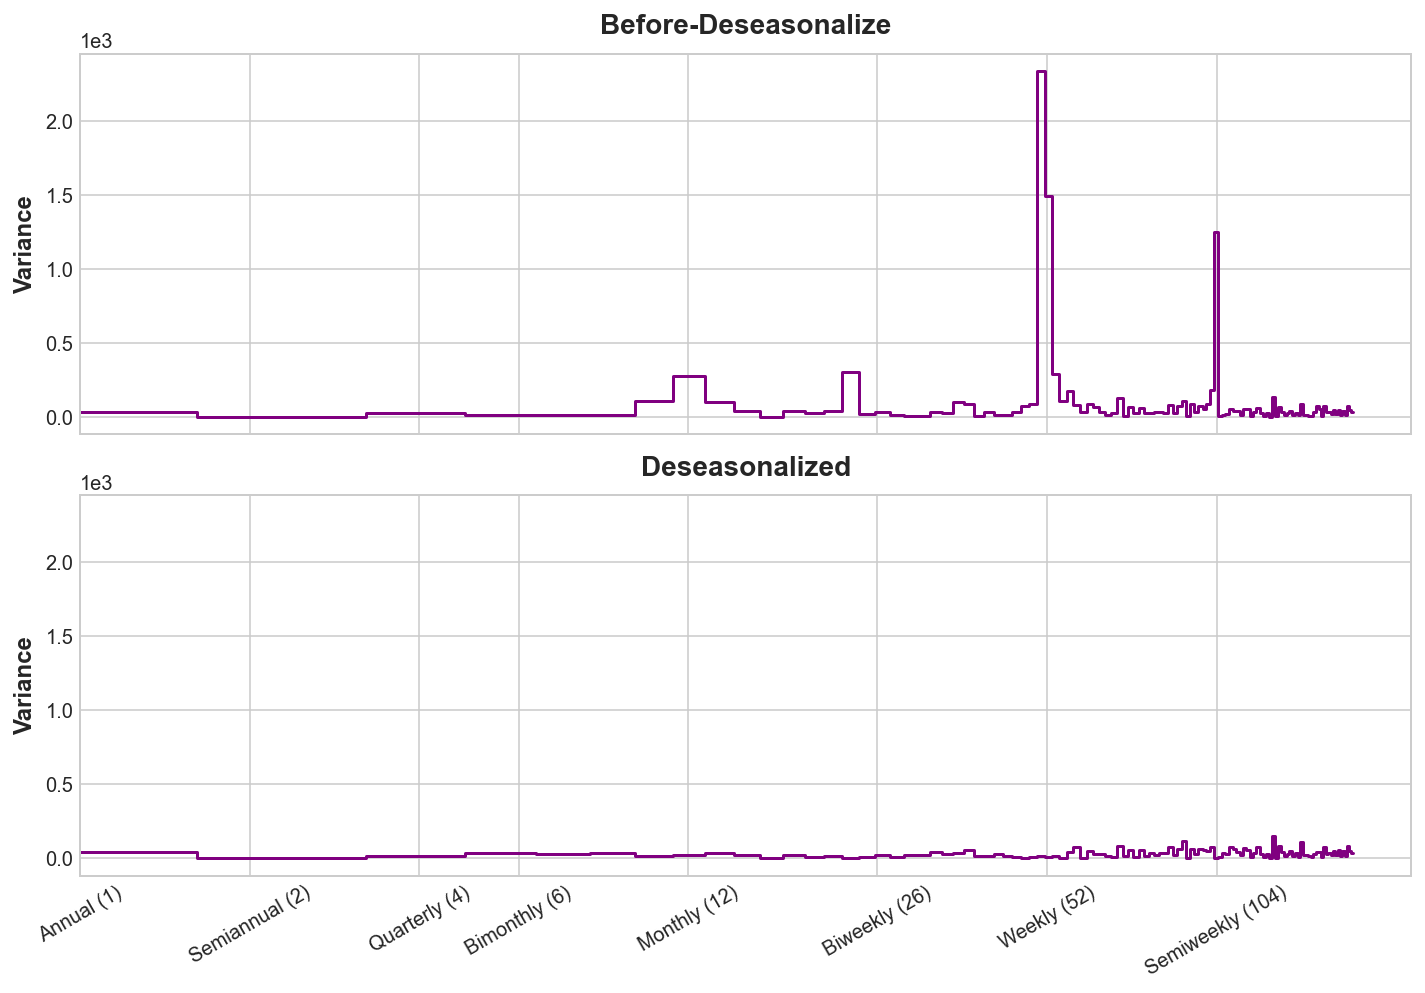

In [47]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Before-Deseasonalize")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

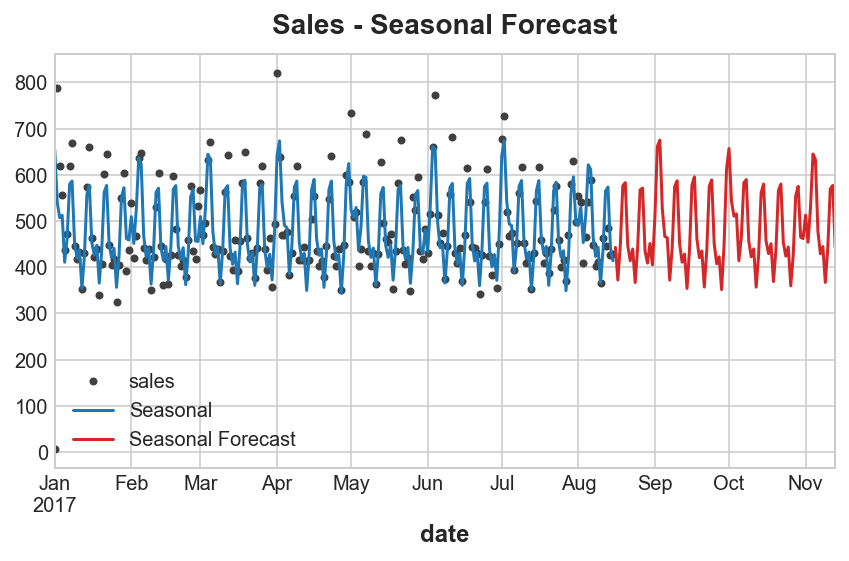

In [48]:

ax = y.plot(color='0.25', style='.', title="Sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

In [49]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_log_error as msle

In [50]:
y_deseason

date
2017-01-01   -646.895992
2017-01-02    246.665065
2017-01-03    112.620599
2017-01-04     43.382111
2017-01-05     25.715551
                 ...    
2017-08-11     26.696323
2017-08-12   -119.604419
2017-08-13    -87.534263
2017-08-14    -14.760334
2017-08-15     14.360773
Freq: D, Length: 227, dtype: float64

#### Including Holiday data

In [51]:
holiday_df = pd.read_csv("../dataset/store-sales-time-series-forecasting/holidays_events.csv")

In [52]:
holiday_df

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [53]:
holiday_df.locale= holiday_df.locale.astype("category")
holiday_df.type= holiday_df.type.astype("category")
holiday_df.locale_name= holiday_df.locale_name.astype("category")
holiday_df.description= holiday_df.description.astype("category")
holiday_df.transferred= holiday_df.transferred.astype("bool")


In [54]:
holiday_df.date = pd.to_datetime(holiday_df.date, infer_datetime_format=True)

In [55]:
holiday_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    category      
 2   locale       350 non-null    category      
 3   locale_name  350 non-null    category      
 4   description  350 non-null    category      
 5   transferred  350 non-null    bool          
dtypes: bool(1), category(4), datetime64[ns](1)
memory usage: 10.5 KB


In [56]:
holiday_df

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [57]:
holiday_df = holiday_df.set_index("date").to_period("D")

In [58]:
holidays = holiday_df.query('type in ["Holiday", "Additional", "Bridge", "Transfer"] & locale in ["National", "Regional"] & transferred in [False]')

In [59]:
holidays_2017 = holidays.loc['2017':'2017-08-15']

In [60]:
holidays_2017

,type,locale,locale_name,description,transferred
date,,,,,
2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False
2017-02-27,Holiday,National,Ecuador,Carnaval,False
2017-02-28,Holiday,National,Ecuador,Carnaval,False
2017-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2017-04-14,Holiday,National,Ecuador,Viernes Santo,False
2017-05-01,Holiday,National,Ecuador,Dia del Trabajo,False
2017-05-13,Additional,National,Ecuador,Dia de la Madre-1,False
2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
2017-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False


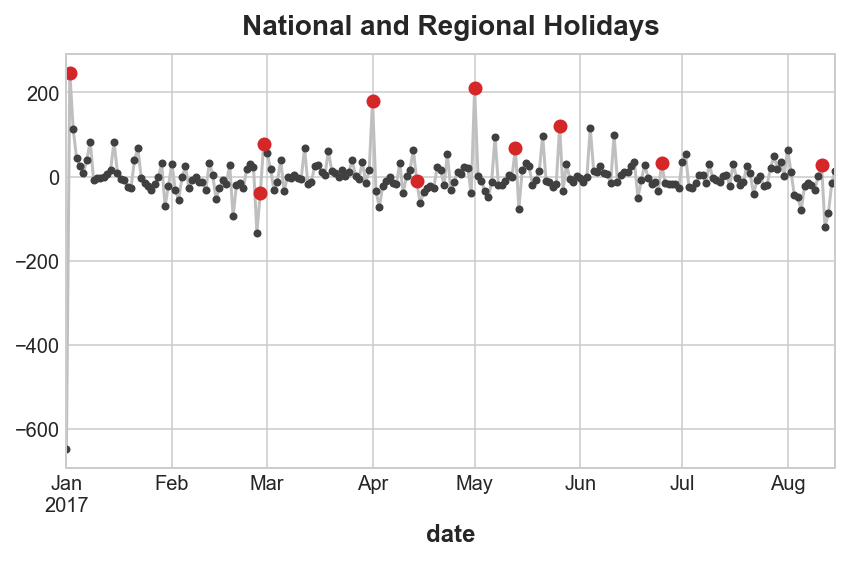

In [61]:
ax = y_deseason.plot(**plot_params) 
plt.plot_date(holidays_2017.index, y_deseason[holidays_2017.index], color='C3')
ax.set_title('National and Regional Holidays');

- average sales do have a seasonal effect due to holidays, hence adding holidays features into the time dependence model.

In [62]:
holidays_2017_encoded = pd.get_dummies(holidays_2017[["type", "locale", "locale_name"]])

In [63]:
holidays_2017_encoded

,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,locale_Local,locale_National,locale_Regional,locale_name_Ambato,...,locale_name_Machala,locale_name_Manta,locale_name_Puyo,locale_name_Quevedo,locale_name_Quito,locale_name_Riobamba,locale_name_Salinas,locale_name_Santa Elena,locale_name_Santo Domingo,locale_name_Santo Domingo de los Tsachilas
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-02-27,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-02-28,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-04-01,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2017-04-14,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-01,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-13,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-26,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-06-25,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
XX_holidays = XX.join(holidays_2017_encoded, on="date").fillna(0)

In [65]:
XX_holidays

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,locale_name_Machala,locale_name_Manta,locale_name_Puyo,locale_name_Quevedo,locale_name_Quito,locale_name_Riobamba,locale_name_Salinas,locale_name_Santa Elena,locale_name_Santo Domingo,locale_name_Santo Domingo de los Tsachilas
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-13,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


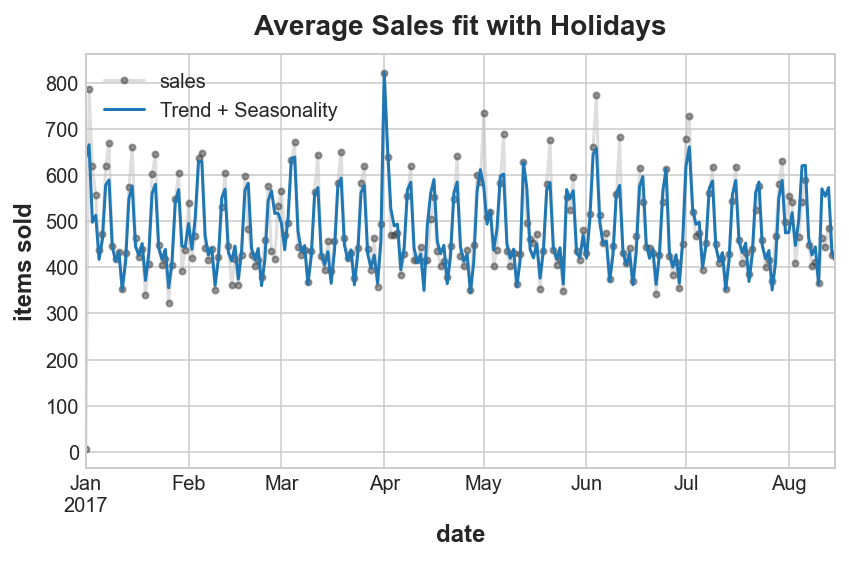

In [66]:
y = X_2017["sales"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(XX_holidays, y)

y_pred = pd.Series(model.predict(XX_holidays), index=y.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales fit with Holidays", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Trend + Seasonality")
ax.legend();

#### Oil Data

In [67]:
oil_df.date = pd.to_datetime(oil_df.date, infer_datetime_format=True)

In [68]:
oil_df = oil_df.set_index("date").to_period("D")

In [69]:
XX_holidays_oil = XX_holidays.join(oil_df, on="date").fillna(method="ffill")

In [70]:
XX_holidays_oil

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,locale_name_Manta,locale_name_Puyo,locale_name_Quevedo,locale_name_Quito,locale_name_Riobamba,locale_name_Salinas,locale_name_Santa Elena,locale_name_Santo Domingo,locale_name_Santo Domingo de los Tsachilas,dcoilwtico
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.36
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.26
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.81
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.81
2017-08-13,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.81


#### adding week indicator

In [71]:
XX_holidays_oil.columns

Index(['const', 'trend', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)',
       's(7,7)', 'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)',
       'cos(2,freq=M)', 'sin(3,freq=M)', 'cos(3,freq=M)', 'sin(4,freq=M)',
       'cos(4,freq=M)', 'type_Additional', 'type_Bridge', 'type_Event',
       'type_Holiday', 'type_Transfer', 'type_Work Day', 'locale_Local',
       'locale_National', 'locale_Regional', 'locale_name_Ambato',
       'locale_name_Cayambe', 'locale_name_Cotopaxi', 'locale_name_Cuenca',
       'locale_name_Ecuador', 'locale_name_El Carmen',
       'locale_name_Esmeraldas', 'locale_name_Guaranda',
       'locale_name_Guayaquil', 'locale_name_Ibarra', 'locale_name_Imbabura',
       'locale_name_Latacunga', 'locale_name_Libertad', 'locale_name_Loja',
       'locale_name_Machala', 'locale_name_Manta', 'locale_name_Puyo',
       'locale_name_Quevedo', 'locale_name_Quito', 'locale_name_Riobamba',
       'locale_name_Salinas', 'locale_name_Santa Elena',
       'locale_name_Santo

In [72]:
XX_holidays_oil["dayofweek"] = XX_holidays_oil.index.dayofweek

In [73]:
XX_holidays_oil.columns

Index(['const', 'trend', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)',
       's(7,7)', 'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)',
       'cos(2,freq=M)', 'sin(3,freq=M)', 'cos(3,freq=M)', 'sin(4,freq=M)',
       'cos(4,freq=M)', 'type_Additional', 'type_Bridge', 'type_Event',
       'type_Holiday', 'type_Transfer', 'type_Work Day', 'locale_Local',
       'locale_National', 'locale_Regional', 'locale_name_Ambato',
       'locale_name_Cayambe', 'locale_name_Cotopaxi', 'locale_name_Cuenca',
       'locale_name_Ecuador', 'locale_name_El Carmen',
       'locale_name_Esmeraldas', 'locale_name_Guaranda',
       'locale_name_Guayaquil', 'locale_name_Ibarra', 'locale_name_Imbabura',
       'locale_name_Latacunga', 'locale_name_Libertad', 'locale_name_Loja',
       'locale_name_Machala', 'locale_name_Manta', 'locale_name_Puyo',
       'locale_name_Quevedo', 'locale_name_Quito', 'locale_name_Riobamba',
       'locale_name_Salinas', 'locale_name_Santa Elena',
       'locale_name_Santo

In [74]:
XX_holidays_oil = pd.get_dummies(XX_holidays_oil, columns=['dayofweek'], drop_first=True)

In [75]:
XX_holidays_oil.columns

Index(['const', 'trend', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)',
       's(7,7)', 'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)',
       'cos(2,freq=M)', 'sin(3,freq=M)', 'cos(3,freq=M)', 'sin(4,freq=M)',
       'cos(4,freq=M)', 'type_Additional', 'type_Bridge', 'type_Event',
       'type_Holiday', 'type_Transfer', 'type_Work Day', 'locale_Local',
       'locale_National', 'locale_Regional', 'locale_name_Ambato',
       'locale_name_Cayambe', 'locale_name_Cotopaxi', 'locale_name_Cuenca',
       'locale_name_Ecuador', 'locale_name_El Carmen',
       'locale_name_Esmeraldas', 'locale_name_Guaranda',
       'locale_name_Guayaquil', 'locale_name_Ibarra', 'locale_name_Imbabura',
       'locale_name_Latacunga', 'locale_name_Libertad', 'locale_name_Loja',
       'locale_name_Machala', 'locale_name_Manta', 'locale_name_Puyo',
       'locale_name_Quevedo', 'locale_name_Quito', 'locale_name_Riobamba',
       'locale_name_Salinas', 'locale_name_Santa Elena',
       'locale_name_Santo

In [91]:
XX_holidays_oil

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,locale_name_Santa Elena,locale_name_Santo Domingo,locale_name_Santo Domingo de los Tsachilas,dcoilwtico,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,NaN,0,0,0,0,0,1
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.0,0.0,0.0,NaN,0,0,0,0,0,0
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,52.36,1,0,0,0,0,0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,53.26,0,1,0,0,0,0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,53.77,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,...,0.0,0.0,0.0,48.81,0,0,0,1,0,0
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,...,0.0,0.0,0.0,48.81,0,0,0,0,1,0
2017-08-13,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,...,0.0,0.0,0.0,48.81,0,0,0,0,0,1


In [103]:
XX_holidays_oil.dropna(inplace=True)

In [104]:
XX_holidays_oil.isnull().sum()

const                                         0
trend                                         0
s(2,7)                                        0
s(3,7)                                        0
s(4,7)                                        0
s(5,7)                                        0
s(6,7)                                        0
s(7,7)                                        0
sin(1,freq=M)                                 0
cos(1,freq=M)                                 0
sin(2,freq=M)                                 0
cos(2,freq=M)                                 0
sin(3,freq=M)                                 0
cos(3,freq=M)                                 0
sin(4,freq=M)                                 0
cos(4,freq=M)                                 0
type_Additional                               0
type_Bridge                                   0
type_Event                                    0
type_Holiday                                  0
type_Transfer                           

In [105]:
XX_holidays_oil

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,locale_name_Santa Elena,locale_name_Santo Domingo,locale_name_Santo Domingo de los Tsachilas,dcoilwtico,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,52.36,1,0,0,0,0,0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,53.26,0,1,0,0,0,0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,53.77,0,0,1,0,0,0
2017-01-06,1.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.848644,0.528964,...,0.0,0.0,0.0,53.98,0,0,0,1,0,0
2017-01-07,1.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.937752,0.347305,...,0.0,0.0,0.0,53.98,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,...,0.0,0.0,0.0,48.81,0,0,0,1,0,0
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,...,0.0,0.0,0.0,48.81,0,0,0,0,1,0
2017-08-13,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,...,0.0,0.0,0.0,48.81,0,0,0,0,0,1


In [107]:
y = X_2017["sales"].iloc[2:]




In [108]:
y

date
2017-01-03    619.740234
2017-01-04    555.608032
2017-01-05    436.375397
2017-01-06    471.156128
2017-01-07    619.419922
                 ...    
2017-08-11    463.733856
2017-08-12    444.798279
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Freq: D, Name: sales, Length: 225, dtype: float32

In [109]:
from sklearn.model_selection import train_test_split
idx_train, idx_valid = train_test_split(y.index, test_size=15, shuffle=False)

In [110]:
idx_train

PeriodIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
             '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
             '2017-01-11', '2017-01-12',
             ...
             '2017-07-22', '2017-07-23', '2017-07-24', '2017-07-25',
             '2017-07-26', '2017-07-27', '2017-07-28', '2017-07-29',
             '2017-07-30', '2017-07-31'],
            dtype='period[D]', name='date', length=210)

In [111]:
X_train, X_valid = XX_holidays_oil.loc[idx_train], XX_holidays_oil.loc[idx_valid]
y_train, y_valid = y.loc[idx_train], y.loc[idx_valid]


In [112]:
y_valid

date
2017-08-01    554.729370
2017-08-02    541.364746
2017-08-03    408.568176
2017-08-04    464.520599
2017-08-05    541.915649
2017-08-06    588.978210
2017-08-07    447.511200
2017-08-08    402.786957
2017-08-09    411.975128
2017-08-10    365.536987
2017-08-11    463.733856
2017-08-12    444.798279
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Freq: D, Name: sales, dtype: float32

In [113]:
LRmodel = LinearRegression(fit_intercept=True) 

LRmodel.fit(X_train, y_train)

LinearRegression()

In [114]:

y_fit = pd.DataFrame(LRmodel.predict(X_train), index=X_train.index)

y_pred = pd.DataFrame(LRmodel.predict(X_valid), index=X_valid.index)




In [115]:
y_fit

,0
date,
2017-01-03,509.361458
2017-01-04,517.497359
2017-01-05,415.498382
2017-01-06,458.780501
2017-01-07,579.741702
...,...
2017-07-27,337.378619
2017-07-28,401.509695
2017-07-29,549.107005


In [123]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse

print(f'MAE:{mae(y_train, y_fit):.5f}')
print(f'MAE:{mae(y_valid, y_pred):.5f}')
print(f'RMSE:{rmse(y_train, y_fit, squared=False):.5f}')
print(f'RMSE:{rmse(y_valid, y_pred, squared=False):.5f}')

MAE:22.87250
MAE:44.52829
RMSE:33.51892
RMSE:58.04636


In [ ]:
msle()

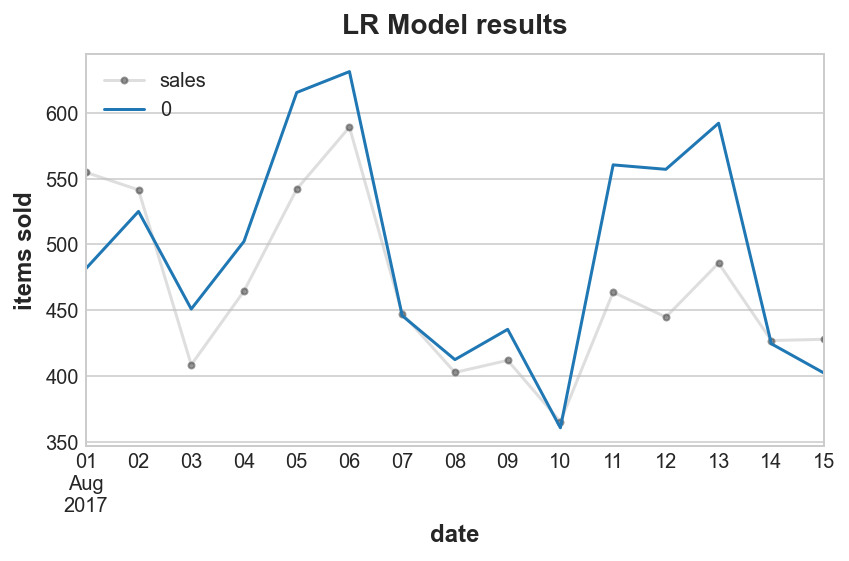

In [118]:
ax = y_valid.plot(**plot_params, alpha=0.5, title="LR Model results", ylabel="items sold")
ax = y_pred.plot(ax=ax)
ax.legend();

In [119]:
from lazypredict.Supervised import LazyRegressor

In [121]:
reg = LazyRegressor()
models,predictions = reg.fit(X_train, X_valid, y_train, y_valid)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 19.31it/s]


In [122]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
KernelRidge,18.71,-52.12,456.67,0.01
Lars,18.57,-51.72,454.94,0.02
GaussianProcessRegressor,16.68,-46.03,429.71,0.02
MLPRegressor,14.96,-40.88,405.48,0.22
LinearSVR,6.86,-16.58,262.73,0.01
ExtraTreeRegressor,1.83,-1.48,98.76,0.01
RANSACRegressor,1.37,-0.10,65.58,0.14
QuantileRegressor,1.36,-0.09,65.50,0.40
DummyRegressor,1.36,-0.07,64.88,0.01


### References
- https://www.statsmodels.org/dev/examples/notebooks/generated/deterministics.html
- https://github.com/gautampawnesh/learntools